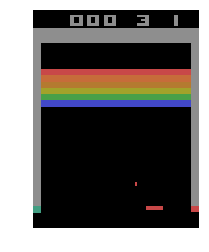

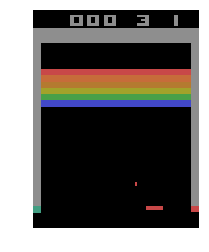

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
def show_state(env):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
#     plt.title("%s | Step: %d %s" % (env._spec.id,step, info))
    plt.axis('off')
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    
env = gym.make('Breakout-v0')

for _ in range(20):  
    observation=env.reset()  
    for t in range(100):  
        show_state(env)
        action=env.action_space.sample()  
        observation,reward,done,info=env.step(action) 
        

        if done:  
            print("Episode finished after {} timesteps".format(t+1))  
            break 
    
    
    
    
    

In [66]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"
import sys
import cv2  # OPENCV2
import cv2 as cv



import gym
import tensorflow as tf
import numpy as np
import random
from collections import deque
from gym import wrappers


CNN_INPUT_WIDTH = 80
CNN_INPUT_HEIGHT = 80
CNN_INPUT_DEPTH = 1
SERIES_LENGTH = 4

REWARD_COFF = 3.0

INITIAL_EPSILON = 1.0
FINAL_EPSILON = 0.0001
REPLAY_SIZE = 50000
BATCH_SIZE = 32
GAMMA = 0.99
OBSERVE_TIME = 500
ENV_NAME = 'Breakout-v4'
EPISODE = 100000
STEP  = 1500
TEST = 10


class ImageProcess():
    def ColorMat2B(self, state):   # this is the function used for the game flappy bird
        height = 80
        width = 80
        state_gray = cv2.cvtColor( cv2.resize( state, ( height, width ) ) , cv2.COLOR_BGR2GRAY )
        _,state_binary = cv2.threshold( state_gray, 5, 255, cv2.THRESH_BINARY )
        state_binarySmall = cv2.resize( state_binary, ( width, height ))
        cnn_inputImage = state_binarySmall.reshape( ( height, width ) )
        return cnn_inputImage

    def ColorMat2Binary(self, state):
        # state_output = tf.image.rgb_to_grayscale(state_input)
        # state_output = tf.image.crop_to_bounding_box(state_output, 34, 0, 160, 160)
        # state_output = tf.image.resize_images(state_output, 80, 80, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        # state_output = tf.squeeze(state_output)
        # return state_output

        height = state.shape[0]
        width = state.shape[1]
        nchannel = state.shape[2]

        sHeight = int(height * 0.5)
        sWidth = CNN_INPUT_WIDTH

        state_gray = cv2.cvtColor(state, cv2.COLOR_BGR2GRAY)
        # print state_gray.shape
        # cv2.imshow('test2', state_gray)
        # cv2.waitKey(0)

        _, state_binary = cv2.threshold(state_gray, 5, 255, cv2.THRESH_BINARY)

        state_binarySmall = cv2.resize(state_binary, (sWidth, sHeight), interpolation=cv2.INTER_AREA)

        cnn_inputImg = state_binarySmall[25:, :]
        # rstArray = state_graySmall.reshape(sWidth * sHeight)
        cnn_inputImg = cnn_inputImg.reshape((CNN_INPUT_WIDTH, CNN_INPUT_HEIGHT))
        # print cnn_inputImg.shape

        return cnn_inputImg

    def ShowImageFromNdarray(self, state, p):
        imgs = np.ndarray(shape=(4, 80, 80))

        for i in range(0, 80):
            for j in range(0, 80):
                for k in range(0, 4):
                    imgs[k][i][j] = state[i][j][k]

        cv2.imshow(str(p + 1), imgs[0])
        cv2.imshow(str(p + 2), imgs[1])
        cv2.imshow(str(p + 3), imgs[2])
        cv2.imshow(str(p + 4), imgs[3])


class DQN():
    def __init__(self, env):
        self.imageProcess = ImageProcess()
        self.epsilon = INITIAL_EPSILON
        self.replay_buffer = deque()
        self.recent_history_queue = deque()
        self.action_dim = env.action_space.n
        self.state_dim = CNN_INPUT_HEIGHT * CNN_INPUT_WIDTH
        self.time_step = 0

        self.session = tf.InteractiveSession()
        self.create_network()
        # self.create_training_method()
        self.observe_time = 0

        self.merged = tf.summary.merge_all()
        self.summary_writer = tf.summary.FileWriter('./path', self.session.graph)

        self.session.run(tf.initialize_all_variables())

    def create_network(self):

        INPUT_DEPTH = SERIES_LENGTH

        self.input_layer = tf.placeholder(tf.float32, [None, CNN_INPUT_WIDTH, CNN_INPUT_HEIGHT, INPUT_DEPTH],
                                          name='status-input')
        self.action_input = tf.placeholder(tf.float32, [None, self.action_dim])
        self.y_input = tf.placeholder(tf.float32, [None])

        W1 = self.get_weights([8, 8, 4, 32])
        b1 = self.get_bias([32])

        h_conv1 = tf.nn.relu(tf.nn.conv2d(self.input_layer, W1, strides=[1, 4, 4, 1], padding='SAME') + b1)
        conv1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        W2 = self.get_weights([4, 4, 32, 64])
        b2 = self.get_bias([64])

        h_conv2 = tf.nn.relu(tf.nn.conv2d(conv1, W2, strides=[1, 2, 2, 1], padding='SAME') + b2)
        # conv2 = tf.nn.max_pool( h_conv2, ksize = [ 1, 2, 2, 1 ], strides= [ 1, 2, 2, 1 ], padding= 'SAME' )

        W3 = self.get_weights([3, 3, 64, 64])
        b3 = self.get_bias([64])

        h_conv3 = tf.nn.relu(tf.nn.conv2d(h_conv2, W3, strides=[1, 1, 1, 1], padding='SAME') + b3)
        # conv3 = tf.nn.max_pool( h_conv3, ksize= [ 1,2,2,1], strides=[ 1,2,2,1 ],padding= 'SAME' )




        W_fc1 = self.get_weights([1600, 512])
        b_fc1 = self.get_bias([512])

        # h_conv2_flat = tf.reshape( h_conv2, [ -1, 11 * 11 * 32 ] )
        conv3_flat = tf.reshape(h_conv3, [-1, 1600])

        h_fc1 = tf.nn.relu(tf.matmul(conv3_flat, W_fc1) + b_fc1)

        W_fc2 = self.get_weights([512, self.action_dim])
        b_fc2 = self.get_bias([self.action_dim])

        self.Q_value = tf.matmul(h_fc1, W_fc2) + b_fc2
        Q_action = tf.reduce_sum(tf.multiply(self.Q_value, self.action_input), reduction_indices=1)
        self.cost = tf.reduce_mean(tf.square(self.y_input - Q_action))

        self.optimizer = tf.train.AdamOptimizer(1e-6).minimize(self.cost)

    # def create_training_method(self):
    #
    #   # if len(self.recent_history_queue) > 4:
    #   #   sess = tf.Session()
    #   #   print sess.run(self.Q_value)
    #   # global_step = tf.Variable(0, name='global_step', trainable=True)
    #   # self.optimizer = tf.train.AdamOptimizer( 0.001 ).minimize( self.cost )

    def train_network(self):
        self.time_step += 1

        minibatch = random.sample(self.replay_buffer, BATCH_SIZE)
        state_batch = [data[0] for data in minibatch]
        action_batch = [data[1] for data in minibatch]
        reward_batch = [data[2] for data in minibatch]
        next_state_batch = [data[3] for data in minibatch]
        done_batch = [data[4] for data in minibatch]
        # self.imageProcess.ShowImageFromNdarray( state_batch[0], 1 )

        y_batch = []
        Q_value_batch = self.Q_value.eval(feed_dict={self.input_layer: next_state_batch})

        # print Q_value_batch
        # print self.time_step
        # cv2.waitKey(0)

        # print Q_value_batch.shape

        for i in range(BATCH_SIZE):

            if done_batch[i]:
                y_batch.append(reward_batch[i])
            else:
                y_batch.append(reward_batch[i] + GAMMA * np.max(Q_value_batch[i]))

        self.optimizer.run(feed_dict={

            self.input_layer: state_batch,
            self.action_input: action_batch,
            self.y_input: y_batch

        })




    def percieve(self, state_shadow, action_index, reward, state_shadow_next, done, episode):

        action = np.zeros( self.action_dim )
        action[ action_index ] = 1

        self.replay_buffer.append([state_shadow, action, reward, state_shadow_next, done])

        self.observe_time += 1
        if self.observe_time % 1000 and self.observe_time <= OBSERVE_TIME == 0:
            print(self.observe_time)

        if len(self.replay_buffer) > REPLAY_SIZE:
            self.replay_buffer.popleft()

        if len(self.replay_buffer) > BATCH_SIZE and self.observe_time > OBSERVE_TIME:
            self.train_network()

    def get_greedy_action(self, state_shadow):

        rst = self.Q_value.eval(feed_dict={self.input_layer: [state_shadow]})[0]
        # print rst
        print(np.max( rst ))
        return np.argmax(rst)

    def get_action(self, state_shadow):
        if self.epsilon >= FINAL_EPSILON and self.observe_time > OBSERVE_TIME:
            self.epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / 10000

        action = np.zeros(self.action_dim)
        action_index = None
        if random.random() < self.epsilon:
            action_index = random.randint(0, self.action_dim - 1)
        else:
            action_index = self.get_greedy_action(state_shadow)

        return action_index


    def get_weights(self, shape):
        weight = tf.truncated_normal(shape, stddev=0.01)
        return tf.Variable(weight)

    def get_bias(self, shape):
        bias = tf.constant(0.01, shape=shape)
        return tf.Variable(bias)


def main():
    env = gym.make(ENV_NAME)
    #env = wrappers.Monitor(env,'/home/users/cc/wkspc/artari/video',force=True)
    state_shadow = None
    next_state_shadow = None


    agent = DQN(env)
    total_reward_decade = 0

    # game_state = game.GameState()





    for episode in range(EPISODE):

        total_reward = 0
        state = env.reset()
        state = agent.imageProcess.ColorMat2Binary(state)  # now state is a binary image of 80 * 80
        state_shadow = np.stack((state, state, state, state), axis=2)

        for step in range(STEP):
            env.render()
            action = agent.get_action(state_shadow)

            next_state, reward, done, _ = env.step(action)

            next_state = np.reshape( agent.imageProcess.ColorMat2Binary( next_state ), ( 80,80,1 ) )

            # print next_state.shape
            # print state_shadow.shape
            next_state_shadow = np.append( next_state, state_shadow[ :,:,:3 ], axis= 2 )

            total_reward += reward
            agent.percieve(state_shadow, action, reward, next_state_shadow, done, episode)
            state_shadow = next_state_shadow

            if done:
                break
        print('Episode:', episode, 'Total Point this Episode is:', total_reward)
        total_reward_decade += total_reward
        if episode % 10 == 0:
            print('-------------')
            print('Decade:', episode / 10, 'Total Reward in this Decade is:', total_reward_decade)
            print('-------------')
            total_reward_decade = 0



if __name__ == '__main__':
    main()


ModuleNotFoundError: No module named 'cv2'